# IMPORTANDO

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from numpy.linalg import inv
import scienceplots
import warnings

warnings.filterwarnings("ignore")

plt.style.use(["bmh", "science", "notebook", "grid"])
PRIMARY = "royalblue"
PRIMARY_DARK = "navy"
SECONDARY = "mediumseagreen"
SECONDARY_DARK = "darkgreen"
TERCIARY = "firebrick"
ALTERNATIVE = "darkorange"
TEXT_COLOR = "#212121"
plt.rc("font", family="Arial")

Trace Editing > Common Midpoint (CMP) Sorting > Velocity Analysis > NMO Correction > Stacking (empilhamento) > Post-Stack Migration > Deconvolution > Quality Control and Interpretation

In [4]:
from scipy.signal import butter, filtfilt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [5]:
import os

usb_home = "J:/Universidade/IC"
usb_uff = "F:/Universidade/IC"

if os.path.exists(usb_home + "/Amplitude/amplitude_synth.npy"):
    data_amp = np.load(usb_home + "/Amplitude/amplitude_synth.npy")
else:
    data_amp = np.load(usb_uff + "/Amplitude/amplitude_synth.npy")

if os.path.exists(usb_home + "/Faults/fault_synth.npy"):
    data_faults = np.load(usb_home + "/Faults/fault_synth.npy")
else:
    data_faults = np.load(usb_uff + "/Faults/fault_synth.npy")

if os.path.exists(usb_home + "/Impedance/impedance_synth.npy"):
    data_imp = np.load(usb_home + "/Impedance/impedance_synth.npy")
else:
    data_imp = np.load(usb_uff + "/Impedance/impedance_synth.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_faults)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)
 data shape (256, 256, 256)


In [6]:
# Impedância de baixa
TEXT_COLOR = "#212121"
cutoff_back = 6
cutoff_30hz = 30
fs = 128

imp_30hz = butter_lowpass_filtfilt(data_imp, cutoff_30hz, fs, order=5)
imp_background = butter_lowpass_filtfilt(data_imp, cutoff_back, fs, order=5)

# np.save('J:/Universidade/GIECAR/Data/impedance_30hz.npy', imp_30hz)
# np.save('J:/Universidade/GIECAR/Data/impedance_background.npy', imp_background)

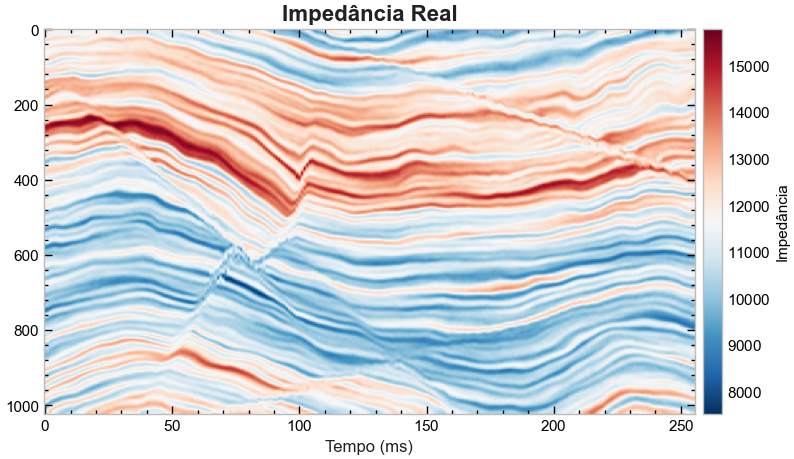

In [7]:
plt.figure(figsize=(10, 5))

impb = plt.imshow(imp_30hz[:, 128, :].T, cmap="RdBu_r", aspect="auto")
plt.title("Impedância Real", fontsize=16, fontweight="bold", color=TEXT_COLOR)
plt.xlabel("Tempo (ms)", fontsize=12, color=TEXT_COLOR)
plt.gca().set_yticklabels([str(int(tick) * 4) for tick in plt.gca().get_yticks()])
cbar = plt.colorbar(impb, pad=0.01)
cbar.set_label("Impedância", size=11)
cbar.ax.tick_params(labelsize=11)
plt.tick_params(axis="both", labelsize=11)

plt.grid()
plt.show()

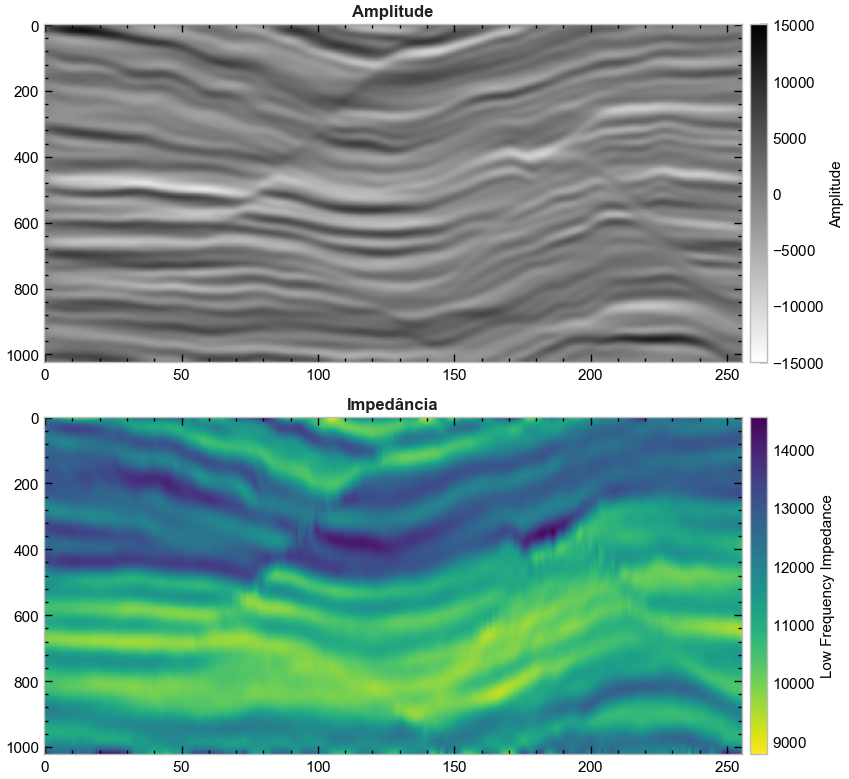

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

c = axs[0].imshow(
    data_amp[128, :, :].T, cmap="gray_r", aspect="auto", vmin=-15000, vmax=15000
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Amplitude", size=11)
cbar.ax.tick_params(labelsize=11)
axs[0].set_title("Amplitude", fontsize=12, fontweight="bold", color=TEXT_COLOR)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=11)
axs[0].grid(False)

c = axs[1].imshow(
    imp_background[128, :, :].T,
    cmap="viridis_r",
    aspect="auto",
    # vmin=8000,
    # vmax=14000
)

cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Low Frequency Impedance", size=11)
cbar.ax.tick_params(labelsize=11)
axs[1].set_title("Impedância", fontsize=12, fontweight="bold", color=TEXT_COLOR)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=11)
axs[1].grid(False)

plt.tight_layout()
plt.show()

taxa de amostragem frequencia de nyquist?

Correlação pearson

# Wavelets

## Gerando a wavelet de Ricker

In [9]:
def ricker(peak_freq, samples, dt):
    # Array do tempo
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Cálculo da wavelet de Ricker
    pi2_f2_t2 = (np.pi**2) * (peak_freq**2) * (t**2)
    ricker = (1.0 - 2.0 * pi2_f2_t2) * np.exp(-pi2_f2_t2)

    return t, ricker


pkfq = 30
dt = 4

twlet, wlet = ricker(peak_freq=pkfq, samples=36, dt=dt)  # wavelet
freqs = np.fft.rfftfreq(twlet.shape[0], d=4 / 1000)
fft = np.abs(np.fft.rfft(wlet))  # / np.max(wlet)
fft = fft / np.max(fft)

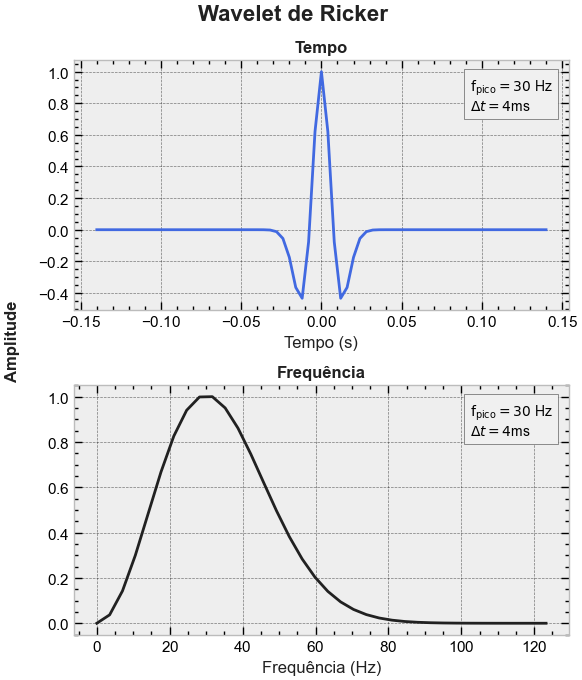

In [10]:
textstr1 = "\n".join(
    (r"$\text{f}_{\text{pico}}=%d$ Hz" % (pkfq), r"$\Delta t=%d$ms" % (dt))
)

plt.rc("font", family="Arial")
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
fig.suptitle("Wavelet de Ricker", fontsize=16, fontweight="bold", color=TEXT_COLOR)
fig.supylabel("Amplitude", fontsize=12, fontweight="bold", color=TEXT_COLOR)

axs[0].plot(twlet, wlet, color=PRIMARY)
axs[0].set_title("Tempo", fontweight="bold", fontsize=12, color=TEXT_COLOR)
axs[0].set_xlabel("Tempo (s)", fontsize=12, color=TEXT_COLOR)
axs[0].tick_params(axis="both", labelsize=11)
axs[0].text(
    0.80,
    0.80,
    textstr1,
    transform=axs[0].transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

axs[1].plot(freqs, fft, color=TEXT_COLOR)
axs[1].set_title("Frequência", fontweight="bold", fontsize=12, color=TEXT_COLOR)
axs[1].set_xlabel("Frequência (Hz)", fontsize=12, color=TEXT_COLOR)
axs[1].tick_params(axis="both", labelsize=11)
axs[1].text(
    0.80,
    0.80,
    textstr1,
    transform=axs[1].transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.tight_layout()
# plt.savefig('simposio_figs/wavelet_ricker.png', dpi=1000, bbox_inches='tight')
plt.show()

In [39]:
# f(t) = (1 - )

## Butterworth

In [11]:
from scipy import signal


def butter_wavelet(freq_hi, freq_low, samples, dt):
    # Calculate time array
    t = np.arange(samples) * (dt / 1000)
    t = np.concatenate((np.flipud(-t[1:]), t), axis=0)

    # Create impulse signal
    imp = signal.unit_impulse(t.shape[0], "mid")

    # Apply high-pass Butterworth filter
    fs = 1000 * (1 / dt)
    b, a = signal.butter(4, freq_hi, fs=fs)
    response_zp = signal.filtfilt(b, a, imp)

    # Apply low-pass Butterworth filter
    low_b, low_a = signal.butter(2, freq_low, "hp", fs=fs)
    butter_wvlt = signal.filtfilt(low_b, low_a, response_zp)

    return t, butter_wvlt


freqhi = 55
freqlow = 10
samplesb = 36
dtb = 4

twlet_b, wlet_b = butter_wavelet(
    freq_hi=freqhi, freq_low=freqlow, samples=samplesb, dt=dtb
)  # wavelet
fft_b = abs(np.fft.rfft(wlet_b))
freqs_b = np.fft.rfftfreq(twlet_b.shape[0], d=4 / 1000)
fft_b = fft_b / np.max(fft_b)

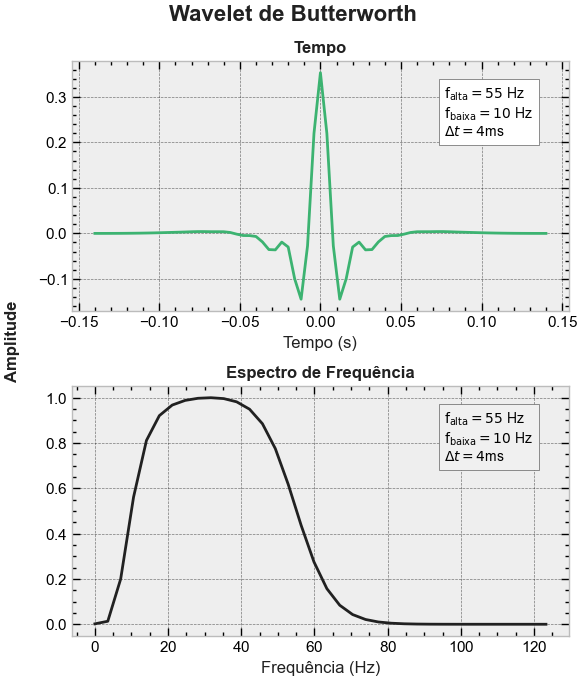

In [12]:
textstr2 = "\n".join(
    (
        r"$\text{f}_{\text{alta}}=%d$ Hz" % (freqhi),
        r"$\text{f}_{\text{baixa}}=%d$ Hz" % (freqlow),
        r"$\Delta t=%d$ms" % (dt),
    )
)

plt.rc("font", family="Arial")
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
fig.suptitle("Wavelet de Butterworth", fontsize=16, fontweight="bold", color=TEXT_COLOR)
fig.supylabel("Amplitude", fontsize=12, fontweight="bold", color=TEXT_COLOR)

axs[0].plot(twlet_b, wlet_b, color=SECONDARY)
axs[0].set_title("Tempo", fontweight="bold", fontsize=12, color=TEXT_COLOR)
axs[0].set_xlabel("Tempo (s)", fontsize=12, color=TEXT_COLOR)
axs[0].tick_params(axis="both", labelsize=11)
axs[0].text(
    0.75,
    0.70,
    textstr2,
    transform=axs[0].transAxes,
    bbox=dict(facecolor="white", edgecolor="#616161"),
)

axs[1].plot(freqs_b, fft_b, color=TEXT_COLOR)
axs[1].set_title(
    "Espectro de Frequência", fontweight="bold", fontsize=12, color=TEXT_COLOR
)
axs[1].set_xlabel("Frequência (Hz)", fontsize=12, color=TEXT_COLOR)
axs[1].tick_params(axis="both", labelsize=11)
axs[1].text(
    0.75,
    0.70,
    textstr2,
    transform=axs[1].transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.tight_layout()
# plt.savefig('simposio_figs/wavelet_butterworth.png', dpi=1000, bbox_inches='tight')
plt.show()

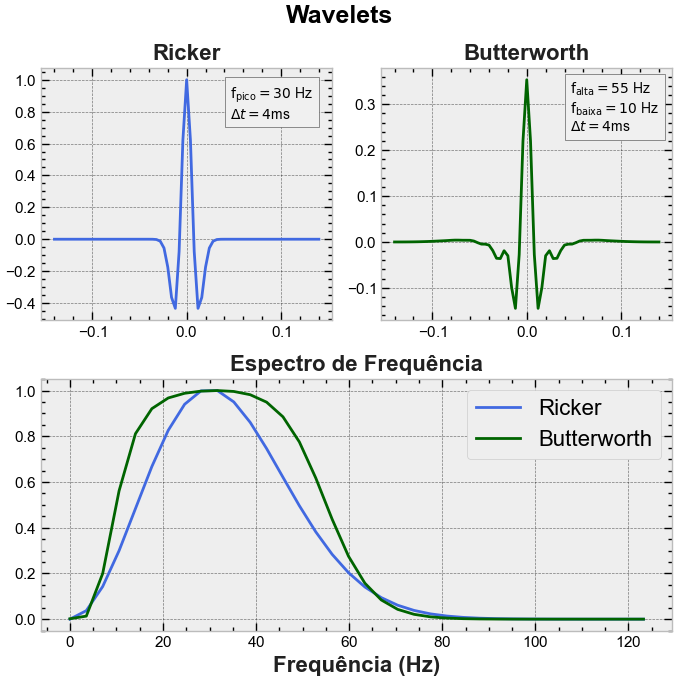

In [31]:
plt.figure(figsize=(7, 7))

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet, color=PRIMARY)
plt.tick_params(axis="both", labelsize=11)
plt.title("Ricker", color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.65,
    0.80,
    textstr1,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b, color=SECONDARY_DARK)
plt.tick_params(axis="both", labelsize=11)
plt.title("Butterworth", color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.65,
    0.75,
    textstr2,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="both", labelsize=11)
plt.plot(freqs, fft, color=PRIMARY, label="Ricker")
plt.title("Espectro de Frequência", color=TEXT_COLOR, fontweight="bold")
plt.plot(freqs_b, fft_b, color=SECONDARY_DARK, label="Butterworth")
plt.xlabel("Frequência (Hz)", color=TEXT_COLOR, fontweight="bold")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("simposio_figs/grid_wavelets.png", dpi=1000, bbox_inches="tight")
plt.show()

# Inversão dos dados

Se está pegando o nz, nx e ny. Fazendo um desenho:
A inversão ocorrerá nas seções nz e nx, ao longo de ny.

<img src="Figures/schematic.png" width=600 height=400>

Então, cada operador PPop precisa ser aplicado em cada seção nz e nx, até o número de ny.

In [32]:
# Parâmetros do operador
nz, nx, ny = data_amp.shape

# Wavelet operator
PPop = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=nx, explicit=True
)

PPop_b = pylops.avo.poststack.PoststackLinearModelling(
    wlet_b / 2, nt0=nz, spatdims=nx, explicit=True
)

## Sem regularização

In [33]:
# Ricker
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_ricker = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section_r = data_amp[:, :, iy]
    impedance_section_r = imp_background[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_section_ricker = (
        pylops.optimization.leastsquares.normal_equations_inversion(
            Op=PPop,
            y=seismic_section_r.flatten(),
            Regs=[],
            epsI=5e-1,  # tikhonov
            x0=impedance_section_r.flatten(),  # modelo inicial
            engine="scipy",
            **dict(maxiter=1000)
        )[0]
    )

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_ricker[:, :, iy] = inverted_impedance_section_ricker.reshape(
        nz, nx
    )

inverted_impedance_final_ricker = inverted_impedance_ricker + imp_background
# Somando-se a impedância de baixa frequência com o modelo de baixa


# Salvar o resultado da inversão (opcional)
# np.save('J:/Universidade/GIECAR/Data/inverted_impedance_ricker.npy', inverted_impedance_final_ricker)

In [34]:
# Butterworth
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_butter = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section_b = data_amp[:, :, iy]
    impedance_section_b = imp_background[:, :, iy]

    inverted_impedance_section_butter = (
        pylops.optimization.leastsquares.normal_equations_inversion(
            Op=PPop_b,
            y=seismic_section_b.flatten(),
            Regs=[],
            epsI=5e-1,  # tikhonov
            x0=impedance_section_b.flatten(),  # modelo inicial
            engine="scipy",
            **dict(maxiter=1000)
        )[0]
    )

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_butter[:, :, iy] = inverted_impedance_section_butter.reshape(
        nz, nx
    )

inverted_impedance_final_butter = inverted_impedance_butter + imp_background
# Somando-se a impedância de baixa frequência com o modelo de baixa

# Salvar o resultado da inversão (opcional)
# np.save('J:/Universidade/GIECAR/Data/inverted_impedance_butter.npy', inverted_impedance_final_butter)

In [35]:
residuo = inverted_impedance_final_ricker - inverted_impedance_final_butter
residuo_ricker = imp_30hz - inverted_impedance_final_ricker
residuo_butter = imp_30hz - inverted_impedance_final_butter

# np.save('J:/Universidade/GIECAR/Data/residuo_ricker.npy', residuo_ricker)
# np.save('J:/Universidade/GIECAR/Data/residuo_butter.npy', residuo_butter)

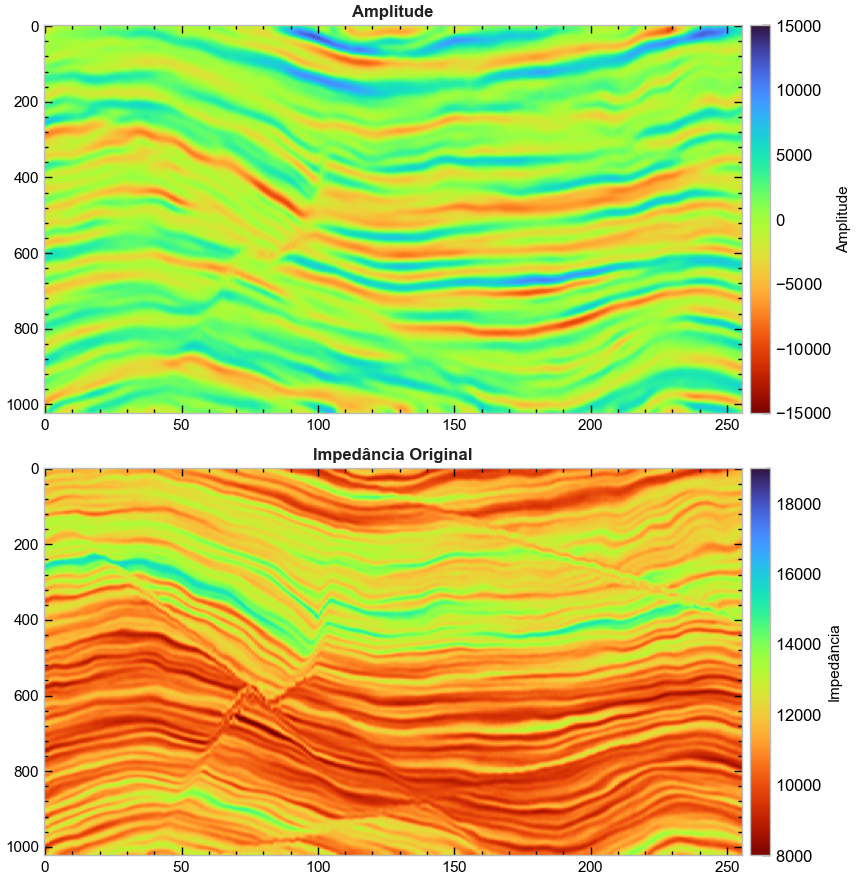

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))

section = 128
colormap = "turbo_r"
plot1, plot2 = axs[0], axs[1]

graph1 = plot1.imshow(
    data_amp[:, 128, :].T, cmap=colormap, aspect="auto", vmin=-15000, vmax=15000
)
plot1.set_title("Amplitude", fontsize=12, fontweight="bold", color=TEXT_COLOR)
plot1.set_yticklabels([str(int(tick) * 4) for tick in plot1.get_yticks()])
plot1.tick_params(axis="both", labelsize=11)
cbar1 = plt.colorbar(graph1, pad=0.01)
cbar1.set_label("Amplitude", size=11)
cbar1.ax.tick_params(labelsize=12)


graph2 = plot2.imshow(
    imp_30hz[:, 128, :].T, cmap=colormap, aspect="auto", vmin=8000, vmax=19000
)
plot2.set_title("Impedância Original", fontsize=12, fontweight="bold", color=TEXT_COLOR)
plot2.set_yticklabels([str(int(tick) * 4) for tick in plot2.get_yticks()])
plot2.tick_params(axis="both", labelsize=11)
cbar2 = plt.colorbar(graph2, pad=0.01)
cbar2.set_label("Impedância", size=11)
cbar2.ax.tick_params(labelsize=12)

plot1.grid(False)
plot2.grid(False)

plt.tight_layout()
plt.savefig("simposio_figs/amplitude_impedancia.png", dpi=500, bbox_inches="tight")
plt.show()
# Amplitude > Impedância Original > Ricker > Butterworth

In [37]:
# Plotar o resíduo de Original - Ricker e Original - Butter
# residuo_ricker e residuo_butterworth

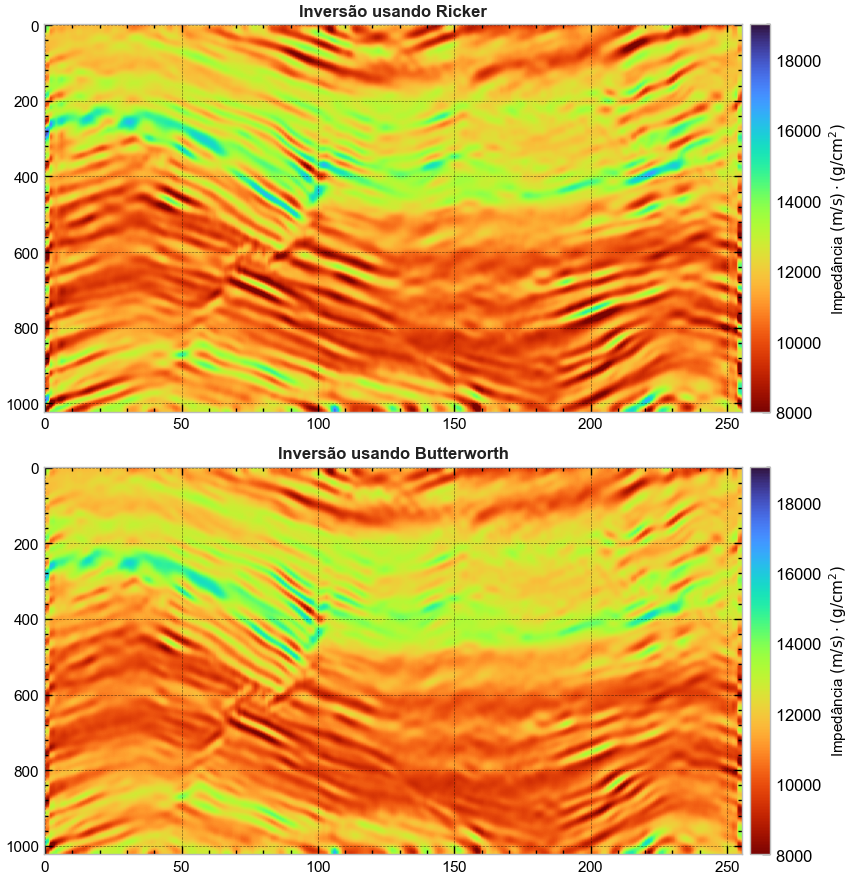

In [61]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))

section = 128
colormap = "turbo_r"
plot1, plot2 = axs[0], axs[1]

graph1 = plot1.imshow(
    inverted_impedance_final_ricker[:, section, :].T,
    cmap=colormap,
    aspect="auto",
    vmin=8000,
    vmax=19000,
)
plot1.set_title(
    "Inversão usando Ricker", fontsize=12, fontweight="bold", color=TEXT_COLOR
)
plot1.set_yticklabels([str(int(tick) * 4) for tick in plot1.get_yticks()])
plot1.tick_params(axis="both", labelsize=11)
cbar1 = plt.colorbar(graph1, pad=0.01)
cbar1.set_label(
    r"Impedância $(\text{m}/\text{s})\cdot(\text{g}/\text{cm}^{2})$", size=11
)
cbar1.ax.tick_params(labelsize=12)


graph2 = plot2.imshow(
    inverted_impedance_final_butter[:, section, :].T,
    cmap=colormap,
    aspect="auto",
    vmin=8000,
    vmax=19000,
)
plot2.set_title(
    "Inversão usando Butterworth", fontsize=12, fontweight="bold", color=TEXT_COLOR
)
plot2.set_yticklabels([str(int(tick) * 4) for tick in plot2.get_yticks()])
plot2.tick_params(axis="both", labelsize=11)
cbar2 = plt.colorbar(graph2, pad=0.01)
cbar2.set_label(
    r"Impedância $(\text{m}/\text{s})\cdot(\text{g}/\text{cm}^{2})$", size=11
)
cbar2.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(
    "simposio_figs/ricker_butterworth_section.png", dpi=500, bbox_inches="tight"
)
plt.show()

## Com regularização

In [ ]:
D2op = pylops.SecondDerivative([nz, nx], axis=1, dtype="float64")

In [ ]:
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_regularized = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = imp_background[:, :, iy]

    # Aplicar a inversão usando o operador PPop e os dados de amplitude
    # A inversão poderia ser algo como:
    # inverted_impedance_regularized_section = algum_algoritmo_de_inversao(PPop, seismic_section, ...)

    # Aqui, você precisa definir 'algum_algoritmo_de_inversao', que pode ser um solver de mínimos quadrados,
    # ou outro método de inversão oferecido pela biblioteca Pylops ou uma customizada por você.
    # Por exemplo, pode ser algo como:
    inverted_impedance_regularized_section = (
        pylops.optimization.leastsquares.regularized_inversion(
            Op=PPop,
            y=seismic_section.flatten(),
            Regs=[D2op],
            x0=impedance_section.flatten(),  # modelo inicial
            **dict(damp=9e-1, iter_lim=1000, show=0)
        )[0]
    )

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_regularized[:, :, iy] = (
        inverted_impedance_regularized_section.reshape(nz, nx)
    )

# Salvar o resultado da inversão (opcional)
# np.save('inverted_impedance_regularized.npy', inverted_impedance_regularized)

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(211)
c = plt.imshow(
    data_amp[150, :, :].T, cmap="gray_r", aspect="auto", vmin=-15000, vmax=15000
)
plt.colorbar(c, pad=0.01).set_label("Amplitude", size=15)

plt.subplot(212)
c = plt.imshow(
    inverted_impedance_regularized[150, :, :].T,
    cmap="viridis_r",
    aspect="auto",
    #    vmin=5000,
    #    vmax=10000
)
plt.colorbar(c, pad=0.01).set_label("Low Frequency Impedance", size=15)

plt.tight_layout()
plt.show()

## FISTA

In [ ]:
# Placeholder para os resultados da impedância acústica invertida
inverted_impedance_FISTA = np.zeros_like(data_imp)

# Loop ao longo do eixo y para aplicar a inversão em cada seção de x-z
for iy in range(ny):
    # Selecionar a seção sísmica e a impedância para a posição atual y
    seismic_section = data_amp[:, :, iy]
    impedance_section = data_imp[:, :, iy]

    inverted_impedance_FISTA_section = pylops.optimization.sparsity.fista(
        Op=PPop,
        y=seismic_section.flatten(),
        x0=impedance_section.flatten(),  # modelo inicial
        niter=1000,
        eps=5 - 1,
        tol=1e-1,
    )[0]

    # Colocar o resultado de volta no volume 3D de impedâncias
    inverted_impedance_FISTA[:, :, iy] = inverted_impedance_FISTA_section.reshape(
        nz, nx
    )

# Salvar o resultado da inversão (opcional)
# np.save('inverted_impedance_FISTA.npy', inverted_impedance_FISTA)

In [ ]:
# minimos quadrados sem regularização
plt.imshow(inverted_impedance_FISTA[25, :, :].T, aspect="auto", cmap="gray_r")
plt.colorbar()